In [1]:
import torch
import torch.nn as nn
import ltn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Equiv = ltn.Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.AndProd(), ltn.fuzzy_ops.ImpliesReichenbach()))
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=6), quantifier="e")

sat_agg = ltn.fuzzy_ops.SatAgg(ltn.fuzzy_ops.AggregMean())


In [3]:
torch.manual_seed(0)

In [4]:

class SimpleModel(nn.Module):
    def __init__(self, hidden_sizes=[]):
        super(SimpleModel, self).__init__()
        self.thetas = nn.Parameter(torch.Tensor([0,0]))
        self.sigmoid = nn.Sigmoid()

        input_size = 2
        self.hidden_sizes = hidden_sizes
        self.layers = nn.Sequential()
        for hidden_size in self.hidden_sizes:
            lin = nn.Linear(input_size, hidden_size, bias=False)
            lin.weight.requires_grad_(False)
            self.layers.append(lin)
            self.layers.append(nn.ReLU())
            input_size = hidden_size
        lin = nn.Linear(input_size, 1, bias=False)
        lin.weight.requires_grad_(False)
        self.layers.append(lin)

    def forward(self, x, y):
        xy = torch.cat([x, y], dim=-1)
        xy = self.thetas * xy
        xy = self.layers(xy.view(-1, 2))
        truth = self.sigmoid(xy)
        return truth

model = SimpleModel()


In [5]:
# Define constants (objects)
constants_tensor = torch.linspace(-10, 10, steps=200)  # Example constants

# Number of objects
num_objects = len(constants_tensor)

model = SimpleModel()

# Initialize the model
pred = ltn.Predicate(model)


In [6]:
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
# Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesKleeneDienes())
# Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesGodel())
# Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesGoguen())
# Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesLuk())

# Implies = ltn.Connective(ImpliesReichenbachSigmoidal(s=3))
# Implies = ltn.Connective(ImpliesReichenbachSigmoidal(s=9))
# Implies = ltn.Connective(ImpliesReichenbachSigmoidal(s=18))


Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
# Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=10), quantifier="f")
# Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregMin(), quantifier="f")
# Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregMean(), quantifier="f")


# sat_agg = ltn.fuzzy_ops.SatAgg(ltn.fuzzy_ops.AggregMin())
sat_agg = ltn.fuzzy_ops.SatAgg(ltn.fuzzy_ops.AggregMean())
# sat_agg = ltn.fuzzy_ops.SatAgg()


In [7]:
def compute_ltn_loss(pred, theta1_val, theta2_val, constants_tensor):
    x = ltn.Variable("x", constants_tensor)
    y = ltn.Variable("y", constants_tensor)
    z = ltn.Variable("z", constants_tensor)
    
    # Set model parameters to the specified values
    pred.model.thetas.data = torch.Tensor([theta1_val, theta2_val])
    
    # Define the predicate with current parameters
    C = pred
    
    # Define Logical Axioms
    axioms = []

    # axioms.append(C(ltn.Constant(constants_tensor[0]), ltn.Constant(constants_tensor[1])))
    # axioms.append(C(ltn.Constant(constants_tensor[1]), ltn.Constant(constants_tensor[0])))
    
    # # Example Axiom: Reflexivity (C(x, x) is true for all x)
    # axioms.append(Forall([x], C(x, x)))
    
    # Example Axiom: Symmetry (C(x, y) implies C(y, x))
    axioms.append(Forall([x, y], Implies(C(x, y), C(y, x))))


    # axioms.append(Forall([x, y], Implies(C(x, y), Not(C(y, x)))))

    # # Example Axiom: Transitivity (C(x, y) and C(y, z) implies C(x, z))
    # axioms.append(Forall([x, y, z], Implies(And(C(x, y), C(y, z)), C(x, z))))

    # Compute satisfiability
    satisfiability = sat_agg(*axioms)
    
    # Compute loss as 1 - satisfiability
    loss = 1.0 - satisfiability
    # loss = satisfiability
    
    return loss

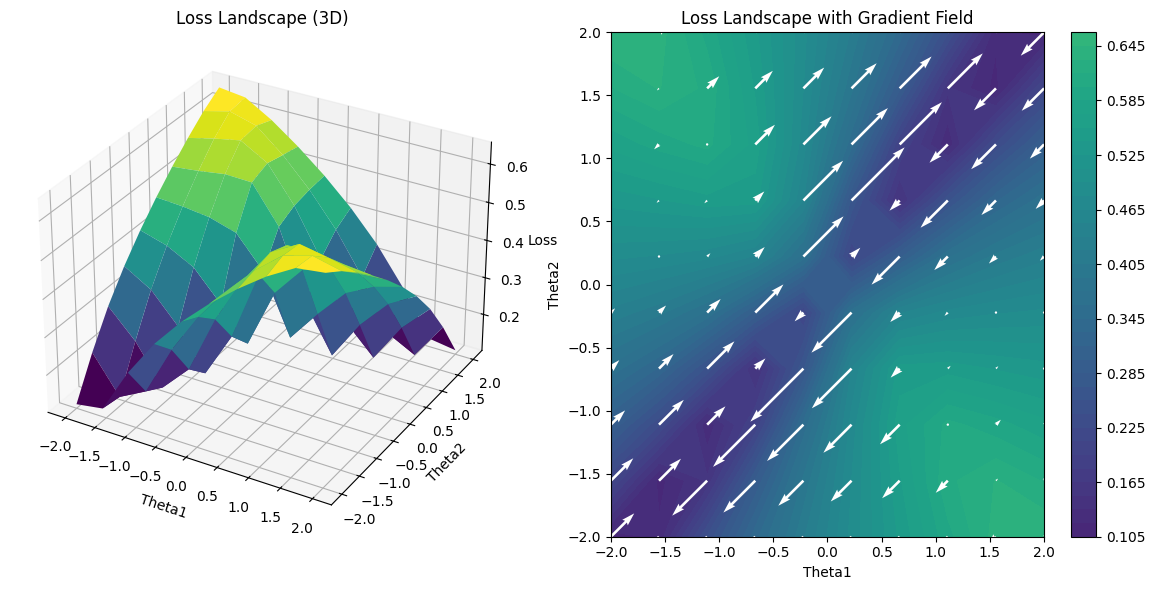

In [8]:

# Define the range for theta1 and theta2
theta1_vals = np.linspace(-2, 2, 10)
theta2_vals = np.linspace(-2, 2, 10)

# Create a meshgrid
Theta1, Theta2 = np.meshgrid(theta1_vals, theta2_vals)

# Initialize a grid to store loss values
Loss = np.zeros_like(Theta1)

# Compute gradients for each (theta1, theta2) pair
Grad_Theta1 = np.zeros_like(Theta1)
Grad_Theta2 = np.zeros_like(Theta2)

for i in range(len(theta1_vals)):
    for j in range(len(theta2_vals)):
        if pred.model.thetas.grad is not None:
            pred.model.thetas.grad.zero_()

        
        # Compute loss for current theta1 and theta2
        loss = compute_ltn_loss(pred, theta1_vals[i], theta1_vals[j], constants_tensor)
        
        # Backpropagate to compute the gradients
        # loss_tensor = torch.tensor(loss, requires_grad=True)
        loss.backward(retain_graph=True)


        
        # Store the gradients (which are in the .grad attribute)
        Grad_Theta1[j, i] = pred.model.thetas.grad[0].item()
        Grad_Theta2[j, i] = pred.model.thetas.grad[0].item()

        Loss[j, i] = loss.item()

# Plotting the loss landscape with gradients
fig = plt.figure(figsize=(12, 6))

# 3D Surface Plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(Theta1, Theta2, Loss, cmap='viridis', edgecolor='none')
ax.set_title('Loss Landscape (3D)')
ax.set_xlabel('Theta1')
ax.set_ylabel('Theta2')
ax.set_zlabel('Loss')

# Contour Plot with Gradient Field
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contourf(Theta1, Theta2, Loss, levels=50, cmap='viridis', vmin=0, vmax=1)
fig.colorbar(contour, ax=ax2)
ax2.set_title('Loss Landscape with Gradient Field')
ax2.set_xlabel('Theta1')
ax2.set_ylabel('Theta2')

# Add gradient vectors to the contour plot
ax2.quiver(Theta1, Theta2, -Grad_Theta1, -Grad_Theta2, color='white')  # Negative gradients (descent direction)

plt.tight_layout()
plt.show()


/home/job/miniconda3/envs/LTN/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


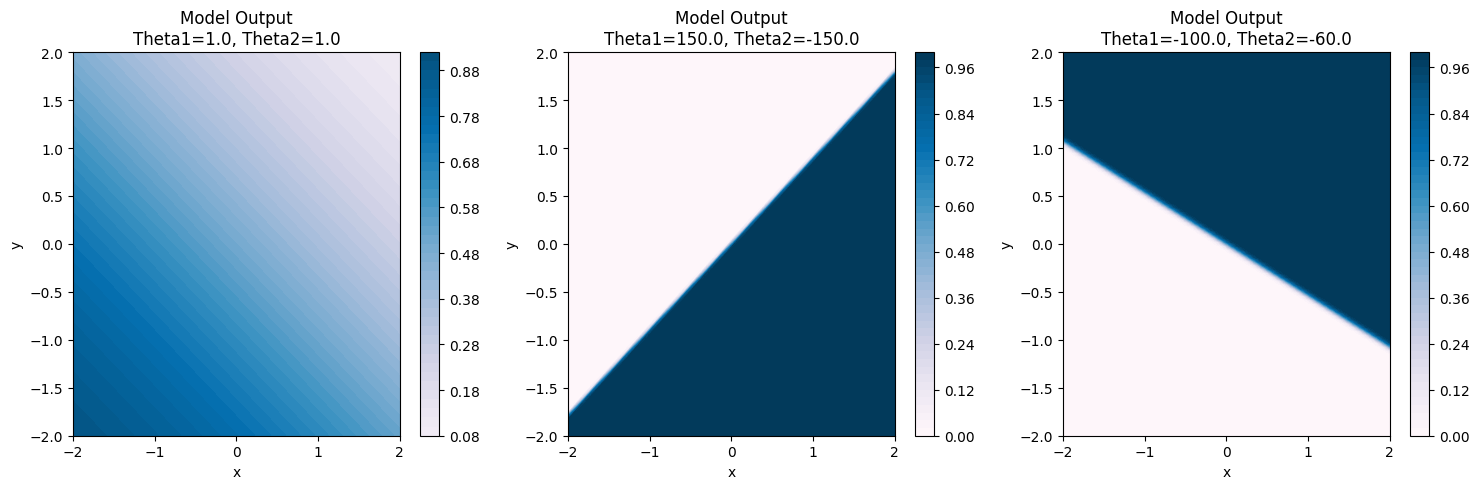

In [9]:
# Step 1: Choose parameter values (theta1, theta2) to inspect
parameter_sets = [
    (1., 1.),
    (150., -150.),
    (-100., -60.)
]

# Step 2: Define the input range (x, y)
steps = 100
x_vals = torch.linspace(-2, 2, steps=steps)
y_vals = torch.linspace(-2, 2, steps=steps)

# Step 3: Create a grid for inputs
X, Y = torch.meshgrid(x_vals, y_vals)
X = X.flatten().view(-1, 1)
Y = Y.flatten().view(-1, 1)

# Step 4: Plot outputs for each parameter set
fig, axes = plt.subplots(1, len(parameter_sets), figsize=(15, 5))
for idx, (theta1_val, theta2_val) in enumerate(parameter_sets):
    # Set model parameters
    model.thetas.data = torch.Tensor([theta1_val, theta2_val])
    # Compute the model output
    with torch.no_grad():
        outputs = model(X, Y).detach().numpy().reshape(steps, steps)

    # Plot the model output as a heatmap
    ax = axes[idx]
    c = ax.contourf(x_vals, y_vals, outputs, levels=50, cmap='PuBu'
                    , vmin=0, vmax=1
                    )
    fig.colorbar(c, ax=ax)
    ax.set_title(f'Model Output\nTheta1={theta1_val}, Theta2={theta2_val}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()


In [10]:
assert False

AssertionError: 

In [241]:
class InvModel(nn.Module):
    def __init__(self, invariance="symmetric", hidden_sizes=[16], Win=8, Wout=8):
        super(InvModel, self).__init__()

        self.invariance = invariance

        self.W = nn.Linear(in_features=Win, out_features=Wout)
        # Determine input size based on invariance type
        if self.invariance == "none":
            self.W2 = nn.Linear(in_features=Win, out_features=Wout)

        # Initialize hidden layers
        self.hidden_sizes = hidden_sizes
        layers = []
        input_size = Wout
        for hidden_size in self.hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size, bias=False))
            layers.append(nn.Tanh())
            input_size = hidden_size
        layers.append(nn.Linear(input_size, 1, bias=False))  # Output layer
        self.layers = nn.Sequential(*layers)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y):
        x = self.W(x)
        if self.invariance == "symmetric":
            y = self.W(y)
        elif self.invariance == "asymmetric":
            y = -self.W(y)
        elif self.invariance == "none":
            y = self.W2(y)
        xy = x + y
        xy = self.layers(xy)
        truth = self.sigmoid(xy)
        return truth

In [242]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

modelkwargs = dict(hidden_sizes=[8], Win=4, Wout = 4)
num_epochs = 500
num_points = 20
dim = modelkwargs["Win"]
train_split = 0.05
eval_per_epochs = 50
batch_size = 64

# Generate a single set of points
def generate_points(num_points=100, dim=8):
    return np.random.rand(num_points, dim).astype(np.float32)

# Create Cartesian products of points and assign labels
# def create_datasets(points):
#     num_points = points.shape[0]
    
#     # Create Cartesian products
#     x = np.repeat(points, num_points, axis=0)  # All points as x
#     y = np.tile(points, (num_points, 1))      # All points as y

#     upper_triangle = np.random.randint(0, 2, size=(num_points, num_points))
#     neither_labels = upper_triangle.ravel().astype(np.float32)
#     upper_triangle = np.triu(upper_triangle, k=1)  # Keep only upper triangular part
    
#     symmetric_matrix = upper_triangle + upper_triangle.T
#     asymmetric_matrix = upper_triangle + np.triu(np.ones_like(upper_triangle), k=1).T * (upper_triangle.T.__neg__() + 1)

#     np.fill_diagonal(symmetric_matrix, np.random.randint(0, 2, size=num_points))

#     symmetric_labels = symmetric_matrix.ravel().astype(np.float32)
#     asymmetric_labels = asymmetric_matrix.ravel().astype(np.float32)

#     return (x, y, symmetric_labels), (x, y, asymmetric_labels), (x, y, neither_labels)

def create_datasets(points):
    num_points = points.shape[0]
    
    # Create Cartesian products (pairs of points)
    x = np.repeat(points, num_points, axis=0)  # All points as x
    y = np.tile(points, (num_points, 1))       # All points as y

    # Mask to remove reflexive pairs (x == y)
    mask = np.repeat(np.arange(num_points), num_points) != np.tile(np.arange(num_points), num_points)

    # Apply mask to x and y to filter out reflexive pairs
    x_filtered = x[mask]
    y_filtered = y[mask]
    
    # Generate random labels for the upper triangular part
    non_diag_values = np.zeros(num_points * (num_points-1) )
    non_diag_values[num_points * (num_points-1)//2:] = 1
    non_diag_values = np.random.permutation(non_diag_values)
    upper_triangle = np.zeros((num_points, num_points))
    non_diag_mask = ~np.eye(num_points, dtype=bool)  # True for non-diagonal elements
    upper_triangle[non_diag_mask] = non_diag_values
    
    # Neither labels (random for the entire matrix)
    neither_labels = upper_triangle.ravel().astype(np.float32)[mask]

    non_diag_values = np.zeros(num_points * (num_points-1)//2)
    non_diag_values[num_points * (num_points-1)//4:] = 1
    non_diag_values = np.random.permutation(non_diag_values)
    upper_triangle = np.zeros((num_points, num_points))
    upper_triangle[np.mask_indices(num_points, np.triu, k=1)] = non_diag_values
    
    # Symmetric labels (symmetric matrix + random diagonal)
    symmetric_matrix = upper_triangle + upper_triangle.T
    symmetric_labels = symmetric_matrix.ravel().astype(np.float32)[mask]
    
    # Asymmetric labels (upper triangular + negation of lower triangular part)
    asymmetric_matrix = upper_triangle + np.triu(np.ones_like(upper_triangle), k=1).T * (upper_triangle.T.__neg__() + 1)
    asymmetric_labels = asymmetric_matrix.ravel().astype(np.float32)[mask]

    return (x_filtered, y_filtered, symmetric_labels), (x_filtered, y_filtered, asymmetric_labels), (x_filtered, y_filtered, neither_labels)

# Create datasets from generated points
points = generate_points(num_points, dim)
symmetric_data, asymmetric_data, neither_data = create_datasets(points)

# Function to create DataLoader
def create_dataloader(data, train_split=0.8, batch_size=32):
    x_data, y_data, labels = data
    dataset = TensorDataset(torch.tensor(x_data), torch.tensor(y_data), torch.tensor(labels))
    train_size = int(train_split * len(dataset))
    eval_size = len(dataset) - train_size
    train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, eval_loader

# Training function
def train_model(model, train_loader, eval_loader, num_epochs=10, learning_rate=0.001, eval_per_epochs=1):
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    eval_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for x_batch, y_batch, label_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch, y_batch)
            loss = criterion(output, label_batch.view(-1, 1))  # Reshape labels
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        if epoch % eval_per_epochs == 0:
            # Evaluation
            # model.eval()
            # epoch_eval_loss = 0
            # with torch.no_grad():
            #     for x_batch, y_batch, label_batch in eval_loader:
            #         output = model(x_batch, y_batch)
            #         loss = criterion(output, label_batch.view(-1, 1))
            #         epoch_eval_loss += loss.item()

            model.eval()
            with torch.no_grad():
                epoch_eval_loss = 0

                for x_batch, y_batch, label_batch in eval_loader:
                    output = model(x_batch, y_batch)
                    accuracy = (output.round() == label_batch.view(-1, 1)).sum()
                    epoch_eval_loss += accuracy.item()

                for x_batch, y_batch, label_batch in train_loader:
                    output = model(x_batch, y_batch)
                    accuracy = (output.round() == label_batch.view(-1, 1)).sum()
                    epoch_eval_loss += accuracy.item()

                avg_eval_loss = epoch_eval_loss / (len(eval_loader.dataset) + len(train_loader.dataset))
                eval_losses.append(avg_eval_loss)

                # print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}')

    return train_losses, eval_losses

In [243]:
# # Train models on each dataset and collect losses
# results = {}

# datasets = {
#     "symmetric": symmetric_data,
#     "asymmetric": asymmetric_data,
#     "neither": neither_data
# }

# for dataset_name, dataset in datasets.items():
#     print(f"\nTraining on {dataset_name} dataset with symmetric invariance:")
#     symmetric_model = InvModel(invariance="symmetric", **modelkwargs)
#     train_loader, eval_loader = create_dataloader(dataset, train_split=train_split, batch_size=batch_size)
#     symmetric_train_losses, symmetric_eval_losses = train_model(symmetric_model, train_loader, eval_loader, num_epochs, eval_per_epochs=eval_per_epochs)
    
#     print(f"\nTraining on {dataset_name} dataset with asymmetric invariance:")
#     asymmetric_model = InvModel(invariance="asymmetric", **modelkwargs)
#     asymmetric_train_losses, asymmetric_eval_losses = train_model(asymmetric_model, train_loader, eval_loader, num_epochs, eval_per_epochs=eval_per_epochs)
    
#     print(f"\nTraining on {dataset_name} dataset with no invariance:")
#     none_model = InvModel(invariance="none", **modelkwargs)
#     none_train_losses, none_eval_losses = train_model(none_model, train_loader, eval_loader, num_epochs, eval_per_epochs=eval_per_epochs)
    
#     results[dataset_name] = {
#         "symmetric": (symmetric_train_losses, symmetric_eval_losses),
#         "asymmetric": (asymmetric_train_losses, asymmetric_eval_losses),
#         "none": (none_train_losses, none_eval_losses)
#     }

# # Plotting the learning curves for all datasets and models
# fig, axs = plt.subplots(3, 2, figsize=(12, 15))
# datasets_list = list(datasets.keys())

# for i, dataset_name in enumerate(datasets_list):
#     for model_type in ['symmetric', 'asymmetric', 'none']:
#         train_losses, eval_losses = results[dataset_name][model_type]
#         axs[i, 0].plot(range(1, num_epochs + 1), train_losses, label=model_type, marker='o')
#         axs[i, 1].plot(range(1, num_epochs + 1, eval_per_epochs), eval_losses, label=model_type, marker='o')

#     axs[i, 0].set_title(f'Train Loss - {dataset_name.capitalize()}')
#     axs[i, 0].set_xlabel('Epochs')
#     axs[i, 0].set_ylabel('Average Loss')
#     axs[i, 0].legend()
#     axs[i, 0].grid(True)

#     axs[i, 1].set_title(f'Eval Loss - {dataset_name.capitalize()}')
#     axs[i, 1].set_xlabel('Epochs')
#     axs[i, 1].set_ylabel('Average Loss')
#     axs[i, 1].legend()
#     axs[i, 1].grid(True)

# plt.tight_layout()
# plt.show()

In [244]:
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())

# Batched training function with positive/negative examples and (a)symmetry axioms
def train_model_with_axioms(model, train_loader, eval_loader, constants_tensor,
                                    symmetry=True, asymmetry=False, num_epochs=10, 
                                    learning_rate=0.001, eval_per_epochs=1, sat_agg=ltn.fuzzy_ops.SatAgg()):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    eval_losses = []
    weight1 = []
    weight2 = []

    
    for epoch in range(num_epochs):
        model.train()


        for x_batch, y_batch, label_batch in train_loader:
            optimizer.zero_grad()

            epoch_train_loss = 0

            pos_indices = torch.where(label_batch == 1)
            neg_indices = torch.where(label_batch == 0)
            
            pos_x = ltn.Variable("pos_x", x_batch[pos_indices])
            pos_y = ltn.Variable("pos_y", y_batch[pos_indices])
            pos_x, pos_y = ltn.diag(pos_x, pos_y)

            neg_x = ltn.Variable("neg_x", x_batch[neg_indices])
            neg_y = ltn.Variable("neg_y", y_batch[neg_indices])
            neg_x, neg_y = ltn.diag(neg_x, neg_y)

            batch_axioms = []

            batch_axioms.append(Forall([pos_x, pos_y], model(pos_x, pos_y)))
            batch_axioms.append(Forall([neg_x, neg_y], Not(model(neg_x, neg_y))))


            if symmetry:
                x = ltn.Variable("x", constants_tensor)
                y = ltn.Variable("y", constants_tensor)
                batch_axioms.append(Forall([x, y], Implies(model(x, y), model(y, x))))
            if asymmetry:
                x = ltn.Variable("x", constants_tensor)
                y = ltn.Variable("y", constants_tensor)
                batch_axioms.append(Forall([x, y], Implies(model(x, y), Not(model(y, x)))))

            # 4. Compute satisfiability using all batched axioms
            satisfiability = sat_agg(*batch_axioms)
            
            # 5. Compute loss
            loss = 1.0 - satisfiability
            loss.backward()
            optimizer.step()
        
            # Store train loss
            epoch_train_loss += loss.item()

            with torch.no_grad():
                weight1.append(model.model.W.weight.data )
                weight2.append(model.model.W2.weight.data)
        
        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Optionally evaluate every few epochs
        if epoch % eval_per_epochs == 0:
            # Evaluation
            model.eval()
            epoch_eval_loss = 0
            with torch.no_grad():
                for x_batch, y_batch, label_batch in eval_loader:
                    output = model.model(x_batch, y_batch)
                    accuracy = (output.round() == label_batch.view(-1, 1)).sum()
                    epoch_eval_loss += accuracy.item()
                for x_batch, y_batch, label_batch in train_loader:
                    output = model.model(x_batch, y_batch)
                    accuracy = (output.round() == label_batch.view(-1, 1)).sum()
                    epoch_eval_loss += accuracy.item()
            
            avg_eval_loss = epoch_eval_loss / (len(eval_loader.dataset) + len(train_loader.dataset))
            eval_losses.append(avg_eval_loss)
    
    return train_losses, eval_losses, weight1, weight2



Training on symmetric dataset with LTN symmetric axiom:

Training on symmetric dataset with LTN asymmetric axiom:


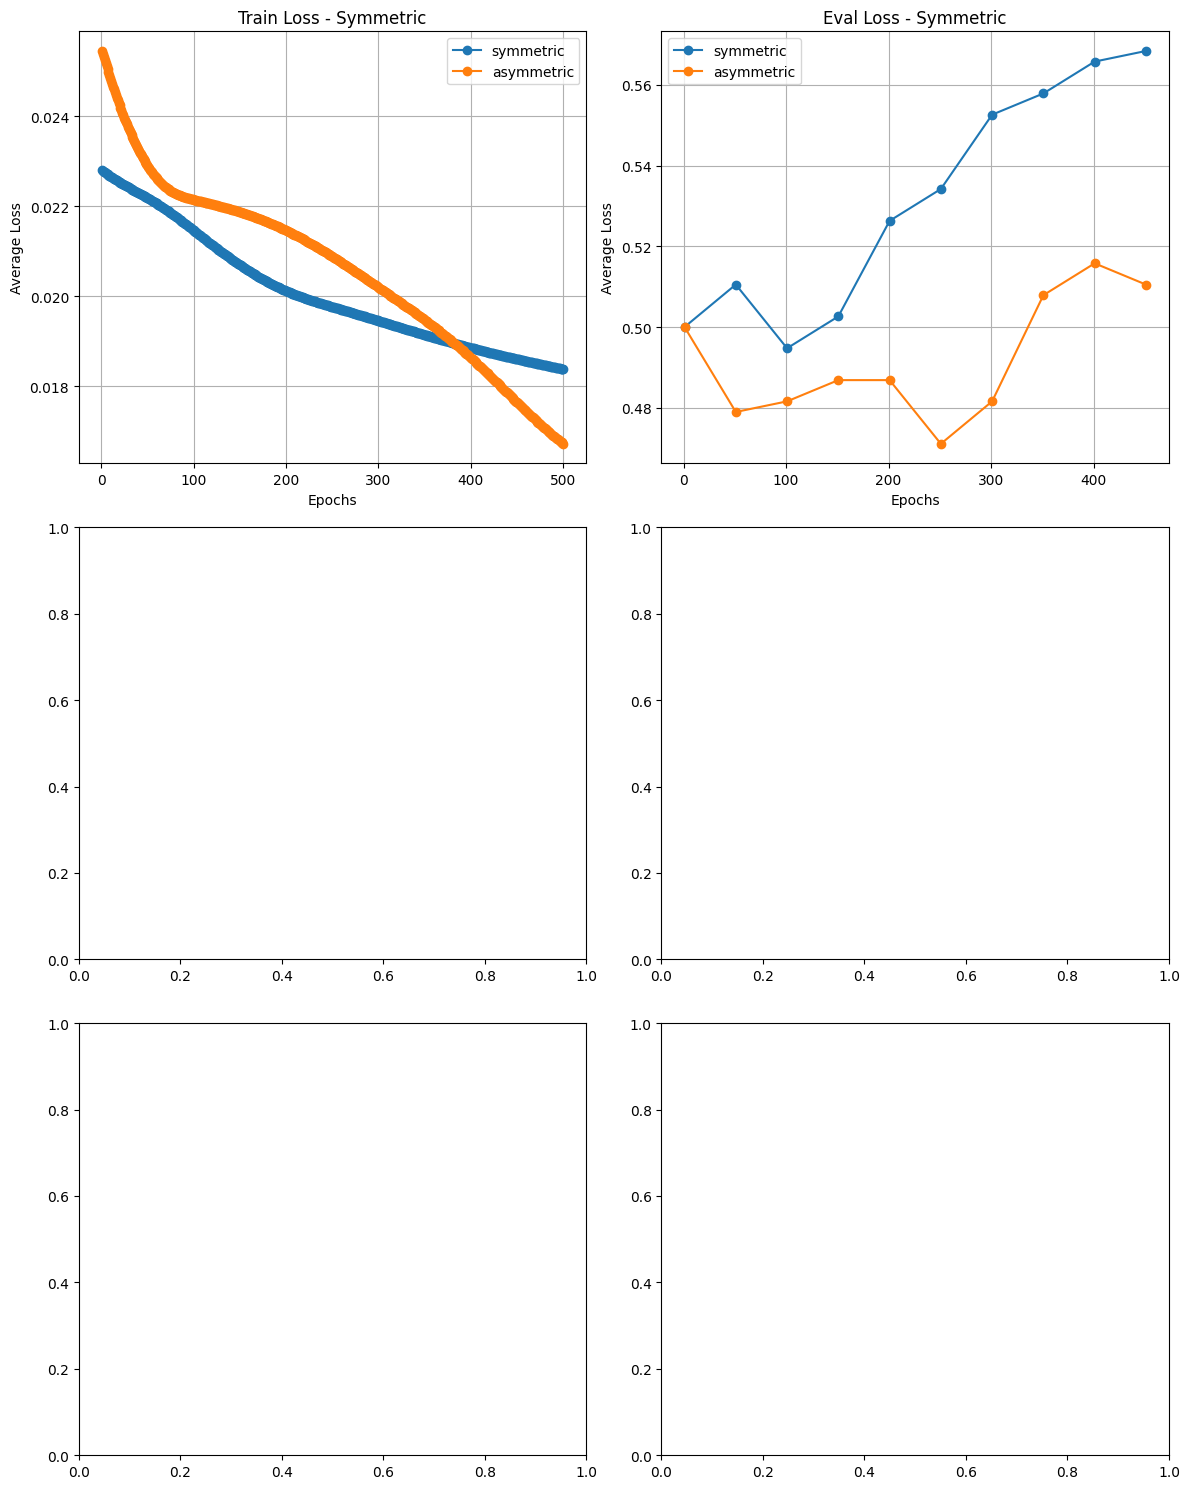

In [245]:
results = {}

datasets = {
    "symmetric": symmetric_data,
    # "asymmetric": asymmetric_data,
    # "neither": neither_data
}
constants_tensor = torch.tensor(points)

for dataset_name, dataset in datasets.items():
    print(f"\nTraining on {dataset_name} dataset with LTN symmetric axiom:")
    symmetric_model = ltn.Predicate(InvModel(invariance="none", **modelkwargs))  # Symmetry is added via axioms
    train_loader, eval_loader = create_dataloader(dataset, train_split=train_split, batch_size=batch_size)    
    symmetric_train_losses, symmetric_eval_losses, symmetric_weight_plus, symmetric_weight_minus = train_model_with_axioms(symmetric_model, train_loader, eval_loader, constants_tensor, symmetry=True, asymmetry=False, num_epochs=num_epochs, eval_per_epochs=eval_per_epochs)
                                                                                 
    print(f"\nTraining on {dataset_name} dataset with LTN asymmetric axiom:")
    asymmetric_model = ltn.Predicate(InvModel(invariance="none", **modelkwargs))  # Asymmetry is added via axioms
    train_loader, eval_loader = create_dataloader(dataset, train_split=train_split, batch_size=batch_size)    
    asymmetric_train_losses, asymmetric_eval_losses, none_weight_plus, asymmetric_weight_minus = train_model_with_axioms(asymmetric_model, train_loader, eval_loader, constants_tensor, symmetry=False, asymmetry=True, num_epochs=num_epochs, eval_per_epochs=eval_per_epochs)
    
    # print(f"\nTraining on {dataset_name} dataset with no invariance:")
    # none_model = ltn.Predicate(InvModel(invariance="none", **modelkwargs))  # No axioms applied
    # train_loader, eval_loader = create_dataloader(dataset, train_split=train_split, batch_size=batch_size)
    # none_train_losses, none_eval_losses, none_weight_plus, asymmetric_weight_minus = train_model_with_axioms(none_model, train_loader, eval_loader, constants_tensor, symmetry=False, asymmetry=False, num_epochs=num_epochs, eval_per_epochs=eval_per_epochs)
    
    results[dataset_name] = {
        "symmetric": (symmetric_train_losses, symmetric_eval_losses, symmetric_weight_plus, symmetric_weight_minus),
        "asymmetric": (asymmetric_train_losses, asymmetric_eval_losses, none_weight_plus, asymmetric_weight_minus),
        # "none": (none_train_losses, none_eval_losses, none_weight_plus, asymmetric_weight_minus )
    }


# Plotting the learning curves for all datasets and models
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
datasets_list = list(datasets.keys())

for i, dataset_name in enumerate(datasets_list):
    for model_type in ['symmetric', 'asymmetric', 
                    #    'none'
                       ]:
        train_losses, eval_losses, _, _ = results[dataset_name][model_type]
        axs[i, 0].plot(range(1, num_epochs + 1), train_losses, label=model_type, marker='o')
        axs[i, 1].plot(range(1, num_epochs + 1, eval_per_epochs), eval_losses, label=model_type, marker='o')

    axs[i, 0].set_title(f'Train Loss - {dataset_name.capitalize()}')
    axs[i, 0].set_xlabel('Epochs')
    axs[i, 0].set_ylabel('Average Loss')
    axs[i, 0].legend()
    axs[i, 0].grid(True)

    axs[i, 1].set_title(f'Eval Loss - {dataset_name.capitalize()}')
    axs[i, 1].set_xlabel('Epochs')
    axs[i, 1].set_ylabel('Average Loss')
    axs[i, 1].legend()
    axs[i, 1].grid(True)

plt.tight_layout()
plt.show()

In [246]:
with torch.no_grad():
    N = constants_tensor.shape[0]
    idx1, idx2 = torch.meshgrid(torch.arange(N), torch.arange(N), indexing='ij')

    x = constants_tensor[idx1]
    y = constants_tensor[idx2]

    preds_symmetric = symmetric_model.model(x, y)
    preds_asymmetric = asymmetric_model.model(x, y)

In [247]:
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesGodel())

with torch.no_grad():
    x = ltn.Variable("x", constants_tensor)
    y = ltn.Variable("y", constants_tensor)
    t = Forall([x, y], Implies(symmetric_model(x, y), symmetric_model(y, x)))
t

LTNObject(value=tensor(0.5059), free_vars=[])

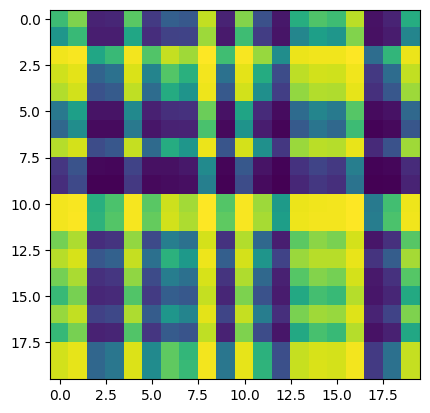

In [248]:
plt.imshow(preds_symmetric)
plt.show()

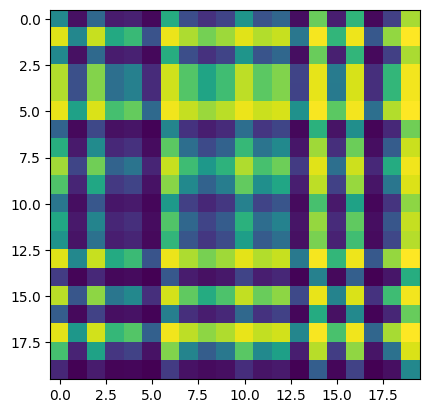

In [249]:
plt.imshow(preds_asymmetric)
plt.show()

In [250]:
from ipywidgets import interact, IntSlider
def plot_mp(heatmap_data):

    def plot_heatmap(frame_index):
        data = heatmap_data[frame_index]
        plt.imshow(data, cmap="PuBu")
        plt.colorbar()
        plt.title(f"Heatmap Frame {frame_index}")

        plt.show()

    num_frames = len(heatmap_data)
    slider = IntSlider(min=0, max=num_frames - 1, step=1, description="Frame")
    interact(plot_heatmap, frame_index=slider)

In [251]:
train_losses, eval_losses, weight1, weight2 = results["symmetric"]['symmetric']

# for a, b in zip(weight1, weight2):
#     print(a.sum(), b.sum())

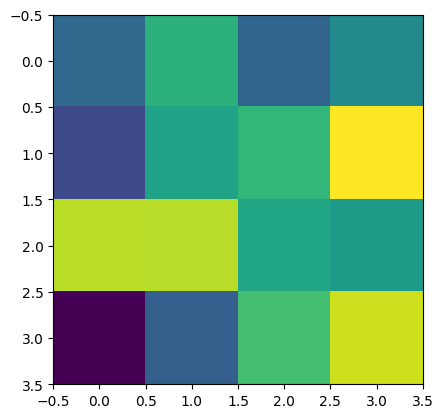

In [252]:
plt.imshow(weight1[-1])
plt.show()

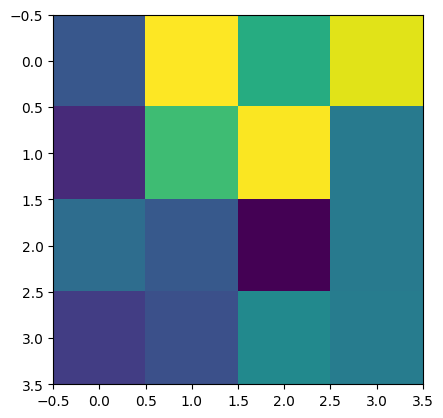

In [253]:
plt.imshow(weight2[-1])
plt.show()